# Optimization Under Uncertainty via Simulation-based Approach

By: [Mansur Arief](https://mansurarief.github.io/)

In this the previous notebook, we learned about deterministic optimization problems. In this notebook, we will add complexity to the problem by considering random parameters, and we will solve optimization under uncertainty problems. We will use the same problem as in the previous notebook, but we will add random parameters to the problem.

## Introduction

Optimization under uncertainty involves random parameters. The random parameters can be modeled as random variables, and the goal of the optimization problem is to find the best decision that minimizes or maximizes the expected objective value (if the parameter of the objective functions are stochastic) while satisfying the possible constraints values (if the parameters of the constraints are strochastic). There are several methods to solve this class of problems, such as simulation-based approach, and robust optimization. In this notebook, we will begin with the simulation-based approach to solve the optimization under uncertain constraints.

## Uncertainty in Constraints

Recall our  *deterministic* linear optimization problem:

\begin{align*}
\text{minimize}~ \quad & Ax + b \\
\text{s.t.} \quad & Cx \leq D \\
& x \in \mathbb{R}^n
\end{align*}

where $b$ is known constants, and $A, C$ and $D$ are known matrices. In this notebook, we will add randomness to the problem by considering random parameters. We will assume that the parameters $A, b,$ and $D$ to be deterministic, while the parameters $C$ to be random, but comes from a bounded set. We will lso assume that the random parameters are independent and identically distributed (i.i.d.). 

### Problem Example

For concreteness, let's assume a 2D problem, i.e. $n=2$, with the following parameters: $A=\begin{bmatrix}1 & 2\end{bmatrix}$, $b=-1$, and $D=\begin{bmatrix}8\\1\\-1\\20\end{bmatrix}$. Meanwhile, $C=\begin{bmatrix}c_{11} & c_{12} \\ c_{21} & c_{22} \\ c_{31} & c_{32} \\ c_{41} & c_{42}\end{bmatrix}$, where 
- $c_{11} \in [-1.2, -0.8]$
- $c_{12} \in [1.8, 2.2]$
- $c_{21} \in [-2.2, -1.8]$
- $c_{22} \in [0.8, 1.2]$
- $c_{31} \in [-0.2, 0.2]$
- $c_{32} \in [-1.2, -0.8]$
- $c_{41} \in [1.8, 2.2]$
- $c_{42} \in [0.8, 1.2]$

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  

def sample_A(num_samples, num_vars, intervals):
    # Sample k matrices of A
    A_samples = np.zeros((num_samples, num_vars))  # Initialize a 3D array to hold k samples of C

    for i in range(num_samples):
        A_samples[i,:] = np.array(
            [np.random.uniform(*intervals['a1']), np.random.uniform(*intervals['a2'])],
        )
        
    return A_samples

def sample_C(num_samples, num_vars, num_constraints, intervals):
    # Sample k matrices of C
    C_samples = np.zeros((num_samples, num_constraints, num_vars))  # Initialize a 3D array to hold k samples of C

    for i in range(num_samples):
        C_samples[i] = np.array([
            [np.random.uniform(*intervals['c11']), np.random.uniform(*intervals['c12'])],
            [np.random.uniform(*intervals['c21']), np.random.uniform(*intervals['c22'])],
            [np.random.uniform(*intervals['c31']), np.random.uniform(*intervals['c32'])],
            [np.random.uniform(*intervals['c41']), np.random.uniform(*intervals['c42'])]
        ])
        
    return C_samples

def plot_constraints_and_feasible_set(C, D, legend=True):
    
    x1_range = np.linspace(-10, 25, 900)
    x2_range = np.linspace(-10, 25, 900)
    X1, X2 = np.meshgrid(x1_range, x2_range)

    fig  = plt.figure(figsize=(8, 6))
    feasible_region = None
    custom_lines = []  
    labels = []  
    colors = [f"C{i}" for i in range(len(D))]

    for j in range(1, len(D) + 1):
        # Construct each constraint based on C and D
        constraint = (C[(j, 1)]*X1 + C[(j, 2)]*X2) - D[j] <= 0
        label = f'${C[(j, 1)]}x_1 + {C[(j, 2)]}x_2 \leq {D[j]}$'
        labels.append(label)

        # Initialize feasible_region or combine with existing
        if feasible_region is None:
            feasible_region = constraint
        else:
            feasible_region &= constraint

        # Plot each constraint line
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="No contour levels were found within the data range.")
            plt.contour(X1, X2, constraint, levels=[0], linestyles='solid', linewidths=1, colors=colors[j-1])
        
        # Add a custom line object for each constraint
        custom_lines.append(Line2D([0], [0], color=colors[j-1], linewidth=1, linestyle='solid'))

    # Plot feasible region
    plt.imshow(feasible_region.astype(int), 
               extent=(x1_range.min(), x1_range.max(), x2_range.min(), x2_range.max()), 
               origin="lower", cmap="Greens", alpha=0.3)

    plt.title('Feasible Set for the Optimization Problem')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.grid(True)
    plt.xlim([-10, 25])
    plt.ylim([-10, 25])

    # Create legend
    if legend:
        plt.legend(custom_lines, labels, loc='upper right', title="Constraints", fontsize=8)

    plt.tight_layout()
    plt.show()
    # fig.savefig('temp.png', transparent=True)
    
def plot_feasible_set_and_objective(C, D, A, b, f_star=None, x_star=None, legend=True):
    x1_range = np.linspace(-10, 25, 900)
    x2_range = np.linspace(-10, 25, 900)
    X1, X2 = np.meshgrid(x1_range, x2_range)

    fig = plt.figure(figsize=(8, 6))
    feasible_region = None
    custom_lines = []  
    labels = []  
    colors = [f"C{i}" for i in range(len(D))]

    # Plot constraints
    for j in range(1, len(D) + 1):
        constraint = (C[(j, 1)]*X1 + C[(j, 2)]*X2) - D[j] <= 0
        label = f'${C[(j, 1)]}x_1 + {C[(j, 2)]}x_2 \leq {D[j]}$'
        labels.append(label)

        if feasible_region is None:
            feasible_region = constraint
        else:
            feasible_region &= constraint

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            plt.contour(X1, X2, constraint, levels=[0], linestyles='solid', linewidths=1, colors=colors[j-1])
        
        custom_lines.append(Line2D([0], [0], color=colors[j-1], linewidth=1, linestyle='solid'))

    # Plot feasible region
    plt.imshow(feasible_region.astype(int), 
               extent=(x1_range.min(), x1_range.max(), x2_range.min(), x2_range.max()), 
               origin="lower", cmap="Greens", alpha=0.3)

    # Plot objective function isovalue contours
    Z = A[1]*X1 + A[2]*X2 + b
    if f_star is not None:
        CS = plt.contour(X1, X2, Z, 50, alpha=0.5, levels=[f_star], colors='k')
        plt.clabel(CS, inline=True, fontsize=8, fmt='%1.1f', colors='k')

    # Mark the optimal solution x_star if provided
    if x_star is not None:
        plt.plot(x_star[0], x_star[1], 'k*', markersize=10, label='$x^*$')

    plt.title('Feasible Set and Objective Isovalues')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.grid(True)
    plt.xlim([-10, 25])
    plt.ylim([-10, 25])

    # Extend the legend with the optimal solution marker
    if x_star is not None:
        custom_lines.append(Line2D([0], [0], color='k', marker='*', linestyle='None', markersize=10))
        labels.append('$x^*$')

    if legend:
        plt.legend(custom_lines, labels, loc='upper right', title="Constraints & Objective", fontsize=8)

    plt.tight_layout()
    plt.show()
    
    
def plot_feasible_set_and_objective_avg(C, D, A, b, f_star=None, x_star=None, num_samples=False, legend=True):
    x1_range = np.linspace(-10, 25, 2500)
    x2_range = np.linspace(-10, 25, 2500)
    X1, X2 = np.meshgrid(x1_range, x2_range)

    fig = plt.figure(figsize=(8, 6))
    feasible_region = None
    custom_lines = []  
    labels = []  
    colors = [f"C{i}" for i in range(len(D))]

    # Plot constraints
    for j in range(1, len(D) + 1):
        constraint = (C[(j, 1)]*X1 + C[(j, 2)]*X2) - D[j] <= 0
        label = f'${C[(j, 1)]}x_1 + {C[(j, 2)]}x_2 \leq {D[j]}$'
        labels.append(label)

        if feasible_region is None:
            feasible_region = constraint
        else:
            feasible_region &= constraint

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            plt.contour(X1, X2, constraint, levels=[0], linestyles='solid', linewidths=1, colors=colors[j-1])
        
        custom_lines.append(Line2D([0], [0], color=colors[j-1], linewidth=1, linestyle='solid'))

    # Plot feasible region
    plt.imshow(feasible_region.astype(int), 
               extent=(x1_range.min(), x1_range.max(), x2_range.min(), x2_range.max()), 
               origin="lower", cmap="Greens", alpha=0.3)

    # Plot objective function isovalue contours
    for k in range(1, num_samples+1):
        Z = A[k, 1]*X1 + A[k, 2]*X2 + b
        
        if f_star is not None:
            CS = plt.contour(X1, X2, Z, 50, alpha=0.5, levels=[f_star], colors='k')
            plt.clabel(CS, inline=True, fontsize=8, fmt='%1.1f', colors='k')

    # Mark the optimal solution x_star if provided
    if x_star is not None:
        plt.plot(x_star[0], x_star[1], 'k*', markersize=10, label='$x^*$')

    plt.title('Feasible Set and Objective Isovalues')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.grid(True)
    plt.xlim([-10, 25])
    plt.ylim([-10, 25])

    # Extend the legend with the optimal solution marker
    if x_star is not None:
        custom_lines.append(Line2D([0], [0], color='k', marker='*', linestyle='None', markersize=10))
        labels.append('$x^*$')

    if legend:
        plt.legend(custom_lines, labels, loc='upper right', title="Constraints & Objective", fontsize=8)

    plt.tight_layout()
    plt.show()
    
    
# Define the intervals for each element of C
intervals = {
    'c11': (-1.2, -0.8),
    'c12': (1.8, 2.2),
    'c21': (-2.2, -1.8),
    'c22': (0.8, 1.2),
    'c31': (-0.2, 0.2),
    'c32': (-1.2, -0.8),
    'c41': (1.8, 2.2),
    'c42': (0.8, 1.2),
}

### Simulation-based Optimization

In this approach, we will generate a number of scenarios for the random parameters, and solve the optimization problem ensuring that the solution is feasible for all scenarios. We begin by setting up the deterministic parameters.

In [2]:
# Given data
num_vars = 2
num_constraints = 4

A = {1: 1, 2: 2}
b = -1
D = {1: 8, 2: 1, 3: -1, 4: 20}

For the random parameters, we will sample `num_samples` scenarios. For simplicity, we will use a uniform distribution for each parameter.

In [3]:
# from utils import sample_C, plot_constraints_and_feasible_set

num_samples = 30
C_samples = sample_C(num_samples, num_vars, num_constraints, intervals)

# Format the samples into a dictionary
flattened_C = C_samples.reshape((-1, num_vars))
C_s = {(i, j): flattened_C[i-1, j-1] for i in range(1, flattened_C.shape[0]+1) for j in range(1, num_vars+1)}

# Duplicate the D values for each sample
D_s = {i+1: D[i %(num_constraints)+1] for i in range(num_constraints*num_samples)}

# Model parameters for pyomo instance later
model_params = {
    None: {
        'A': A,
        'b': {None: b},
        'C': C_s,
        'D': D_s
    }
}

We can now plot the feasible region for each scenario.

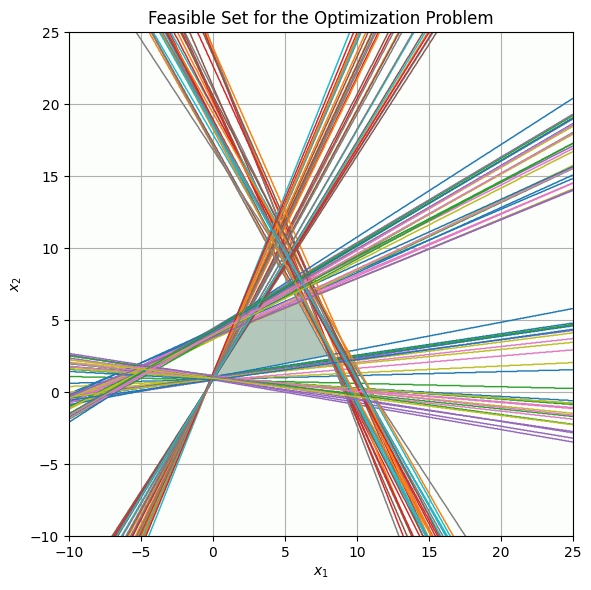

In [4]:
plot_constraints_and_feasible_set(C_s, D_s, False)

It is clear that the feasible region is different for each scenario. The goal of the simulation-based optimization is to find the best decision that is feasible for all scenarios. Similar with the previous problems, we will use `pyomo` library to solve this problem.

### Model Formulation in Pyomo

We begin by importing the necessary libraries. Then, we define the sets and parameters $A$, $b$, $C$, and $D$. Here, we include all realizations of $C$s in the constraint set. The idea is to ensure that the solution is feasible for all realizations of $C$s. Finally, we also define the model and the decision variables $x$.

In [5]:
from pyomo.environ import AbstractModel, Var, Param, Objective, Constraint, SolverFactory, minimize, RangeSet, value, Reals, SolverStatus, TerminationCondition

# Define the abstract model
model = AbstractModel()

# Declare index sets for variables and constraints
model.I = RangeSet(1, num_vars)  
model.J = RangeSet(1, num_constraints*num_samples)  # Note here we neeed to multiply by the number of samples

# Parameters
model.A = Param(model.I, within=Reals)
model.b = Param(within=Reals)
model.C = Param(model.J, model.I, within=Reals)
model.D = Param(model.J, within=Reals)

# Decision Variables
model.x = Var(model.I, domain=Reals)

Finally, we define the objective function and the constraints.

In [6]:
def objective_rule(model):
    return sum(model.A[i] * model.x[i] for i in model.I) + model.b
model.obj = Objective(rule=objective_rule, sense=minimize)

def constraint_rule(model, j):
    return sum(model.C[j, i] * model.x[i] for i in model.I)  <= model.D[j]
model.constraint = Constraint(model.J, rule=constraint_rule)

We use the `AbstractModel` class to define the model, allowing us to defer specifying the values for this parameters until later. We then create an instance of the model by passing the values of the parameters we stored earlier.

In [7]:
# Create a concrete instance of the model
instance = model.create_instance(model_params)

### Solving the Model

Now, that the problem instance is created, we can solve the problem using the `gurobi` solver. You may use other solvers such as `cplex` or `glpk` by changing the solver name. You also need to find the path to the solver executable, and set the path in the `solver` object.

In [8]:
# Solve the concrete instance of the model
solver = SolverFactory('gurobi', executable='/Library/gurobi1100/macos_universal2/bin/gurobi.sh') #change the path to the gurobi.sh file in your system
result = solver.solve(instance, tee=False)

Checking the status of the solution, we can see that the solver has found an optimal solution. We can also print the value of the decision variables and the objective function.

In [9]:
# Print the results
if result.solver.status == SolverStatus.ok and result.solver.termination_condition == TerminationCondition.optimal:
    x_optimal = {i: value(instance.x[i]) for i in instance.I}
    optimal_value = instance.obj()    
    print(f'Optimal solution: {x_optimal}, optimal value: {optimal_value}')
else:
    print('Solver status:', result.solver.status)
    print('Termination condition:', result.solver.termination_condition)

Optimal solution: {1: 0.20101426244491033, 2: 1.16165729237619}, optimal value: 1.5243288471972907


### Extracting the Solution

We can visualize the solution by plotting the feasible region and the optimal solution. We can also extract the value of the decision variables and the objective function.

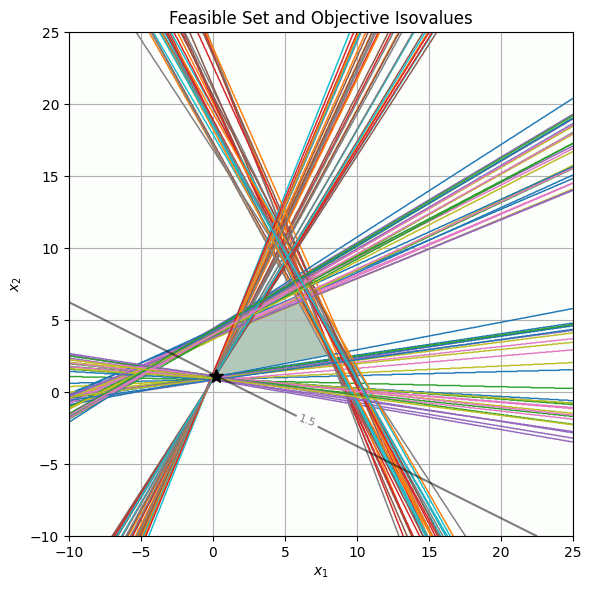

In [10]:
# from utils import plot_feasible_set_and_objective

x_star = [x_optimal[i] for i in instance.I]
f_star = optimal_value

plot_feasible_set_and_objective(C_s, D_s, A, b, f_star, x_star, False)

A couple of remarks here: 

- Note that while in this problem we have a non-empty feasible region, it is possible that the feasible region is empty. In such cases, the solver will return an infeasible status.
- The simulation-based approach can be computationally expensive, especially when the number of scenarios is large. In such cases, we may consider other approaches such as robust optimization.
- It is also possible to have a softer constraint, where the constraint is satisfied with a certain probability. This is known as chance-constrained optimization, and it is a topic of active research in optimization under uncertainty.


## Uncertainty in Objective Function

In the previous example, we considered uncertainty in the constraints. We can also consider uncertainty in the objective function. In this case, we will consider the parameters $A$ to be random, but comes from a bounded set. We will also assume that the random parameters are independent and identically distributed (i.i.d.).


### Problem Example

For concreteness, let's assume a 2D problem, i.e. $n=2$, with the following parameters: $b=-1$, $C=\begin{bmatrix}-1 & -2 \\ -2 & 1 \\ 0 & -1 \\ 2 & 1\end{bmatrix}$, and $D=\begin{bmatrix}8\\1\\-1\\20\end{bmatrix}$. Meanwhile, $A=\begin{bmatrix}a_1 & a_2\end{bmatrix}$, where
- $a_1 \in [0, 2]$
- $a_2 \in [1, 3]$



In [11]:
# Define the intervals for each element of A
intervals = {    
    'a1': (0, 2),
    'a2': (1, 3),
}

Similar to the previous case, we will generate a number of scenarios for the random parameters, and optimize for *the expected value* of the objective function.

In [12]:
# from utils import sample_A

# Given data
num_vars = 2
num_constraints = 4
num_samples = 30

A_samples = sample_A(num_samples, num_vars, intervals)

# Format the samples into a dictionary
A_s = {(i, j): A_samples[i-1, j-1] for i in range(1, A_samples.shape[0]+1) for j in range(1, num_vars+1)}

We can also set the deterministic parameters, then format it into `model_params` dictionary for `pyomo`.

In [13]:

C = {
    (1, 1): -1, (1, 2): 2, 
    (2, 1): -2, (2, 2): 1, 
    (3, 1): 0, (3, 2): -1, 
    (4, 1): 2, (4, 2): 1
}
D = {1: 8, 2: 1, 3: -1, 4: 20}

# Model parameters for pyomo instance later
model_params = {
    None: {
        'A': A_s,
        'b': {None: b},
        'C': C,
        'D': D
    }
}

With this new setting, we can now define the model that optimizes the expected/avg objective value.

In [14]:
# Define the abstract model
model_avg = AbstractModel()

# Declare index sets for variables and constraints
model_avg.I = RangeSet(1, num_vars) 
model_avg.J = RangeSet(1, num_constraints) 
model_avg.K = RangeSet(1, num_samples)  # Index set for samples

# Parameters
model_avg.A = Param(model_avg.K, model_avg.I, within=Reals)
model_avg.b = Param(within=Reals)
model_avg.C = Param(model_avg.J, model_avg.I, within=Reals)
model_avg.D = Param(model_avg.J, within=Reals)

# Decision variables
model_avg.x = Var(model_avg.I, domain=Reals)

The objective function is now the expected value of the objective function, and the constraints are the same as before.

In [15]:
def objective_rule(model_avg):
    return (sum(model_avg.A[k, i] * model_avg.x[i]  + model_avg.b for i in model_avg.I for k in model_avg.K))/num_samples
model_avg.obj = Objective(rule=objective_rule, sense=minimize)

def constraint_rule(model_avg, j):
    return sum(model_avg.C[j, i] * model_avg.x[i] for i in model_avg.I)  <= model_avg.D[j]
model_avg.constraint = Constraint(model_avg.J, rule=constraint_rule)

We can now instantiate the model and solve the problem.

In [16]:
instance_avg = model_avg.create_instance(model_params)
result_avg = solver.solve(instance_avg, tee=False)

The solution can be extracted and visualized as before.

Optimal solution: {1: 0.0, 2: 1.0}, optimal value: 0.01711952386535566


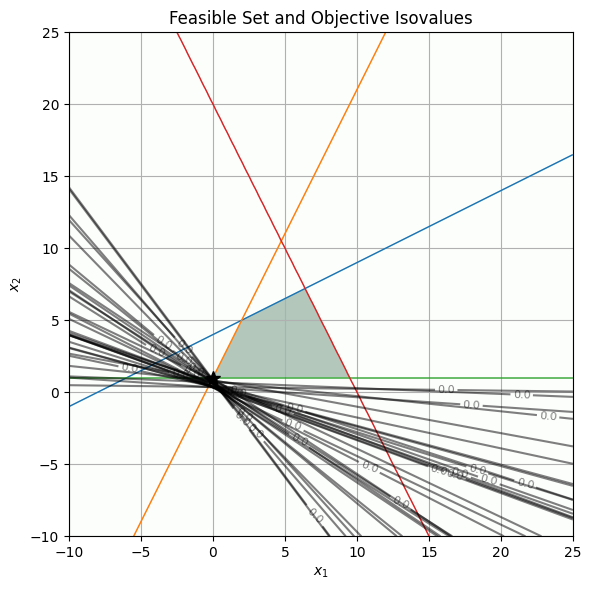

In [17]:
# from utils import plot_feasible_set_and_objective_avg

# Print the results
if result_avg.solver.status == SolverStatus.ok and result_avg.solver.termination_condition == TerminationCondition.optimal:
    x_optimal_avg = {i: value(instance_avg.x[i]) for i in instance_avg.I}
    optimal_value_avg = instance_avg.obj()    
    print(f'Optimal solution: {x_optimal_avg}, optimal value: {optimal_value_avg}')
else:
    print('Solver status:', result_avg.solver.status)
    print('Termination condition:', result_avg.solver.termination_condition)
    
# Visualize
x_star = [x_optimal_avg[i] for i in instance_avg.I]
f_star = optimal_value_avg
    
plot_feasible_set_and_objective_avg(C, D, A_s, b, f_star, x_star, num_samples, False)

### Concluding Remarks

In this notebook, we learned about optimization under uncertainty. We considered two cases: uncertainty in the constraints and uncertainty in the objective function. We mainly used the simulation-based approach to solve the problems. In the next notebook, we will learn about robust optimization, which is another approach to solve optimization under uncertainty problems.

The full notebook with the visualization code and practice set included is available here.

# Practice Problems

1. Consider the following optimization problem with uncertainty in the constraints:
\begin{align*}
\text{minimize}~ \quad & Ax + b \\
\text{s.t.} \quad & Cx \leq D \\
& x \in \mathbb{R}^n
\end{align*}
where $A=\begin{bmatrix}1 & 2\end{bmatrix}$, $b=-1$, and $D=\begin{bmatrix}8\\1\\-1\\20\end{bmatrix}$. Meanwhile, $C=\begin{bmatrix}c_{11} & c_{12} \\ c_{21} & c_{22} \\ c_{31} & c_{32} \\ c_{41} & c_{42}\end{bmatrix}$, where
   - $c_{11} \in [-1.3, -0.7]$
   - $c_{12} \in [1.7, 2.3]$
   - $c_{21} \in [-2.3, -1.7]$
   - $c_{22} \in [0.5, 1.5]$
   - $c_{31} \in [-0.4, 0.4]$
   - $c_{32} \in [-1.4, -0.6]$
   - $c_{41} \in [1.5, 2.5]$
   - $c_{42} \in [0.9, 1.1]$
  
   For this problem, do the following:
      1. Generate 100 scenarios for the random parameters, and solve the optimization problem ensuring that the solution is feasible for all scenarios. Plot the feasible region for each scenario, and visualize the optimal solution.
      2. Generate 1000 scenarios for the random parameters, and solve the optimization problem ensuring that the solution is feasible for all scenarios. Plot the feasible region for each scenario, and visualize the optimal solution.
  
2. Consider the following optimization problem with uncertainty in the objective function:
\begin{align*}
\text{minimize}~ \quad & Ax + b \\
\text{s.t.} \quad & Cx \leq D \\
& x \in \mathbb{R}^n
\end{align*}
where $C=\begin{bmatrix}-1 & -2 \\ -2 & 1 \\ 0 & -1 \\ 2 & 1\end{bmatrix}$, and $D=\begin{bmatrix}8\\1\\-1\\20\end{bmatrix}$. Meanwhile, $A=\begin{bmatrix}a_1 & a_2\end{bmatrix}$ and $b=b_1$, where
   - $a_1 \in [-0.5, 2.5]$
   - $a_2 \in [0.5, 3.5]$
   - $b_1 \in [-2.5, 0.5]$
  